This note book  will illustrate the data exploration prcoess step by step.

In [31]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

The project is centered at creating a model that can predict the price of apartments in the city of Mexico (Distrito federal) for a customer.Paying attention strictly to apartments that cost less than $100,000 USD (< $100,000)

# Prepare Data

## Import

The project contains more than 5 data sets , so instead of cleaning each of them individually, I will utilize creating  a function that will automate the data importing and cleaning process. 

In [32]:
def wrangle(filepath):
    # Read csv file into DataFrame
    df = pd.read_csv(filepath)
    # Subset data: Apartments in "Distrito Federal", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    # Create a borough column and drop the place_with_parent_names column
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    # Drop columns with over 50% null values
    df.drop(columns=["floor" ,"expenses"], inplace=True)
    # Drop low and high cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    # Drop Leaky Columns
    df.drop(columns=["price", "price_aprox_local_currency","price_usd_per_m2", "price_per_m2"], inplace=True)
    # Drop columns with multicolinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    return df

# Exploration

In [13]:
df = wrangle("mexico-city-real-estate-2.csv")
print("df shape:", df.shape)
df.head()

df shape: (4628, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Gustavo A. Madero|Distrito Federal|México|,"19.516777,-99.160149",1200000.0,MXN,1189144.46,63223.78,88.0,88.0,718.452045,13636.363636,NaN,NaN,NaN,http://gustavo-a-madero.properati.com.mx/r644_...
1,sell,apartment,|Gustavo A. Madero|Distrito Federal|México|,"19.466724,-99.131614",480000.0,MXN,475657.74,25289.51,NaN,48.0,NaN,10000.000000,NaN,NaN,NaN,http://vallejo.properati.com.mx/mz4c_venta_dep...
2,sell,apartment,|Álvaro Obregón|Distrito Federal|México|,"19.33228,-99.243934",4559261.0,MXN,4518016.68,240211.43,NaN,126.0,NaN,36184.611111,NaN,NaN,NaN,http://alvaro-obregon.properati.com.mx/jh8j_ve...
3,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1105772788,-86.8537859927",3808088.0,MXN,3774533.79,200682.34,0.0,171.0,NaN,22269.520468,NaN,NaN,NaN,http://cancun.properati.com.mx/qus8_venta_depa...
4,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.39365,-99.14769",1730000.0,MXN,1714349.82,91147.61,NaN,100.0,NaN,17300.000000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/q5my_ven...


Since I want to build a model for apartments in Mexico City (" Distrito Federal") that cost less than $100,000. Looking at the first five rows of our DataFrame, I can already see that there are entries that violates our target condition. So the first cleaning process is to remove those observations from the dataset. Since i'll be using a function to import and clean our data, i'll need to  update the changes there

In [14]:
# Subset data: Apartments in "Distrito Federal", that are less than ($100,000)
mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
mask_apt = df["property_type"] == "apartment"
mask_price = df["price_aprox_usd"] < 100_000
df = df[mask_ba & mask_apt & mask_price]

In [15]:
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Gustavo A. Madero|Distrito Federal|México|,"19.516777,-99.160149",1200000.0,MXN,1189144.46,63223.78,88.0,88.0,718.452045,13636.363636,NaN,NaN,NaN,http://gustavo-a-madero.properati.com.mx/r644_...
1,sell,apartment,|Gustavo A. Madero|Distrito Federal|México|,"19.466724,-99.131614",480000.0,MXN,475657.74,25289.51,NaN,48.0,NaN,10000.000000,NaN,NaN,NaN,http://vallejo.properati.com.mx/mz4c_venta_dep...
4,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.39365,-99.14769",1730000.0,MXN,1714349.82,91147.61,NaN,100.0,NaN,17300.000000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/q5my_ven...
7,sell,apartment,|Cuauhtémoc|Distrito Federal|México|,"19.420356,-99.143597",1792666.0,MXN,1776870.21,94471.66,NaN,1200.0,NaN,1493.888333,NaN,NaN,NaN,http://cuauhtemoc.properati.com.mx/rccj_venta_...
17,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.383327,-99.152712",1694000.0,MXN,1678675.55,89250.90,NaN,90.0,NaN,18822.222222,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/nb7e_ven...


 Now lets pay attention the size of the apartments since its a huge influence on prices of apartment 

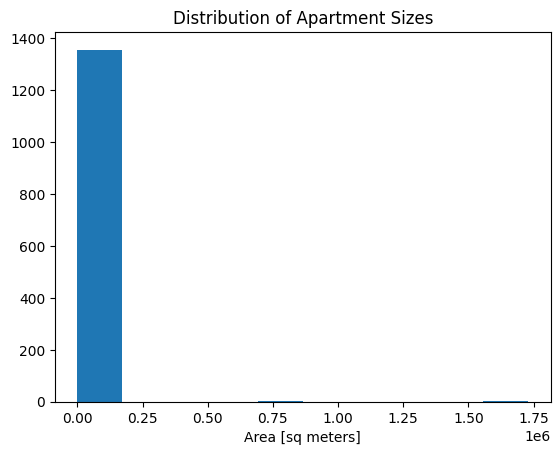

In [16]:
# Create a histogram of "surface_covered_in_m2 to see the distribution of apartment sizes
plt.hist(df["surface_covered_in_m2"])
plt.xlabel('Area [sq meters]')
plt.title("Distribution of Apartment Sizes");

The graphical illustration indicates the presence of outlers which can affect our overall model performance, to further comfirmation, I will check the summary statistics of the feature (surface_covered_in_m2)

In [17]:
df['surface_covered_in_m2'].describe()

count    1.359000e+03
mean     3.216141e+03
std      6.915447e+04
min      0.000000e+00
25%      5.600000e+01
50%      6.500000e+01
75%      7.650000e+01
max      1.730000e+06
Name: surface_covered_in_m2, dtype: float64

The summary statistics of surface_covered_in_m2 confirms that while most of the data are smaller than 76,000 square meters, some are several thousand meters. Best course of action is to remove them from the dataset and add the mask to the wrangle function above.

In [18]:
# Subset data: Remove outliers for "surface_covered_in_m2"
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area = df["surface_covered_in_m2"].between(low, high)
df = df[mask_area]


Now let check the new Histogram

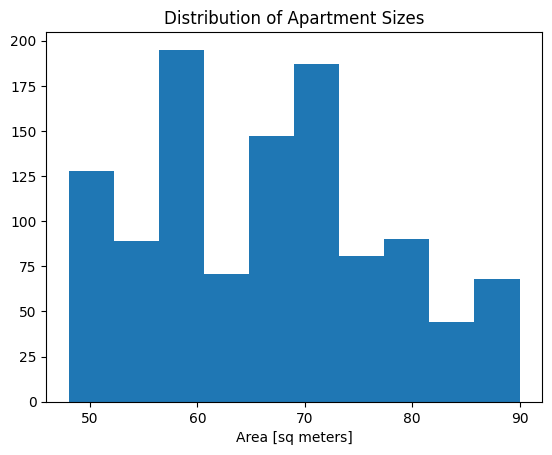

In [19]:
# new histogram
plt.hist(df["surface_covered_in_m2"])
plt.xlabel('Area [sq meters]')
plt.title("Distribution of Apartment Sizes");

Now we consider location then we split the  "lat-lon" column into individual columns and the "lat-lon" column should be dropped. This will also be updated to the wrangle function above.

In [20]:
# Split "lat-lon" column
df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
df.drop(columns="lat-lon", inplace=True)
df.head()

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Gustavo A. Madero|Distrito Federal|México|,1200000.0,MXN,1189144.46,63223.78,88.0,88.0,718.452045,13636.363636,NaN,NaN,NaN,http://gustavo-a-madero.properati.com.mx/r644_...,19.516777,-99.160149
1,sell,apartment,|Gustavo A. Madero|Distrito Federal|México|,480000.0,MXN,475657.74,25289.51,NaN,48.0,NaN,10000.000000,NaN,NaN,NaN,http://vallejo.properati.com.mx/mz4c_venta_dep...,19.466724,-99.131614
17,sell,apartment,|Benito Juárez|Distrito Federal|México|,1694000.0,MXN,1678675.55,89250.90,NaN,90.0,NaN,18822.222222,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/nb7e_ven...,19.383327,-99.152712
19,sell,apartment,|Álvaro Obregón|Distrito Federal|México|,757073.0,MXN,750224.23,39887.51,NaN,60.0,NaN,12617.883333,NaN,NaN,NaN,http://alvaro-obregon.properati.com.mx/pd6s_ve...,19.388280,-99.195529
20,sell,apartment,|Cuauhtémoc|Distrito Federal|México|,806000.0,MXN,798897.99,42475.37,NaN,80.0,NaN,10075.000000,NaN,NaN,NaN,http://cuauhtemoc.properati.com.mx/r3y9_venta_...,19.454582,-99.145651


In the place with parent names column, we can see that there are three distinct strings separated by a '|', they are "borough", "state" and "country" respectively. A borough column would be very useful for the model, so I will create one and drop the place with parent names column.

In [21]:
# Create a borough column and drop the place_with_parent_names column
df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
df.drop(columns="place_with_parent_names", inplace=True)

Now we drop columns that  over 50% null values as data points.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 4623
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1100 non-null   object 
 1   property_type               1100 non-null   object 
 2   price                       1100 non-null   float64
 3   currency                    1100 non-null   object 
 4   price_aprox_local_currency  1100 non-null   float64
 5   price_aprox_usd             1100 non-null   float64
 6   surface_total_in_m2         137 non-null    float64
 7   surface_covered_in_m2       1100 non-null   float64
 8   price_usd_per_m2            98 non-null     float64
 9   price_per_m2                1100 non-null   float64
 10  floor                       0 non-null      float64
 11  rooms                       4 non-null      float64
 12  expenses                    0 non-null      float64
 13  properati_url               1100 

In [23]:
df.isnull().sum() / len(df)


operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.875455
surface_covered_in_m2         0.000000
price_usd_per_m2              0.910909
price_per_m2                  0.000000
floor                         1.000000
rooms                         0.996364
expenses                      1.000000
properati_url                 0.000000
lat                           0.062727
lon                           0.062727
borough                       0.000000
dtype: float64

In [24]:
 # Drop columns with over 50% null values
df.drop(columns=["floor" ,"expenses"], inplace=True)

The next thing we need to look out for are categorical columns with low or high cardinality.

In [25]:
#Cardinality check
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            1
properati_url    1100
borough            15
dtype: int64

Here, we can see that columns like "operation" ,"property_type" have only one value in them, while every row in "properati_url" has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

In [26]:
# Drop low and high cardinality categorical variables
df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

In [27]:
sorted(df.columns)

['borough',
 'lat',
 'lon',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

Now we drop leaky columns - that is they contain information that would not be known or available at the time of making a prediction or decision.

In [28]:
# Drop Leaky Columns
df.drop(columns=["price", "price_aprox_local_currency","price_usd_per_m2", "price_per_m2"], inplace=True)

Finally, the last thing we need look  out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap and investigate the results.

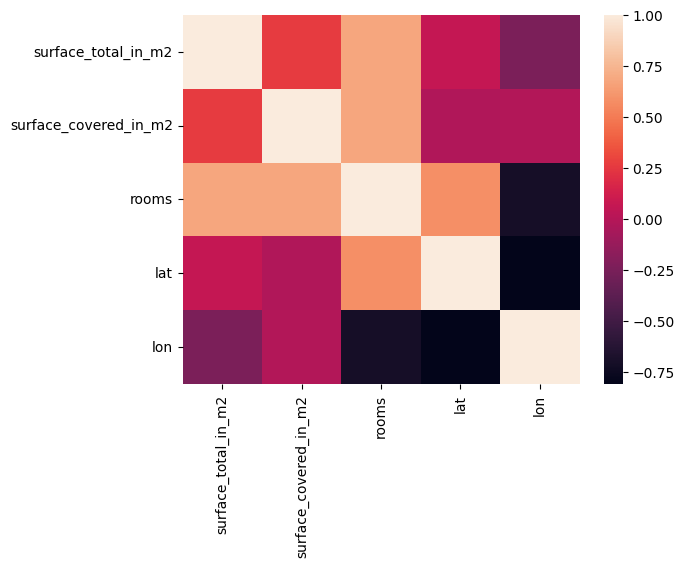

In [29]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

From the heatmap above we can see that the columns with multicolinearity are "surface_total_in_m2" and "rooms" so they will be dropped.

In [30]:
# Drop columns with multicolinearity
df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

In [ ]:
Now lets comfirm our function .

In [33]:
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,63223.78,88.0,19.516777,-99.160149,Gustavo A. Madero
1,25289.51,48.0,19.466724,-99.131614,Gustavo A. Madero
17,89250.90,90.0,19.383327,-99.152712,Benito Juárez
19,39887.51,60.0,19.388280,-99.195529,Álvaro Obregón
20,42475.37,80.0,19.454582,-99.145651,Cuauhtémoc
